In [1]:
!pip install crewai sentence-transformers rank-bm25 faiss-cpu torch transformers networkx matplotlib


  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------- -------------------- 3.9/8.1 MB 23.5 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 22.8 MB/s  0:00:00
Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl (225 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 25.5 MB/s  0:00:00
Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ---------------------------------------- 0/6 [pyparsing]
   ------ --------------------------------- 1/6 [kiwisolver

In [10]:
import json

case_corpus = [
    "The defendant breached their duty of care by failing to maintain safe premises. The plaintiff suffered damages.",
    "Contract interpretation requires examining the intent of the parties.",
    "Negligence claims require proof of duty, breach, causation, and damages.",
    "Corporate liability extends to officers when they participate in tortious conduct. Damages were substantial.",
    "Employment contracts must specify termination clauses clearly. The defendant was negligent."
]
statute_corpus = [
    "Section 1: All persons have the right to equal protection.",
    "Section 2: Contracts require mutual consent."
]


In [11]:
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
import faiss

# Semantic embeddings (FAISS)
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
case_embeddings = embedding_model.encode(case_corpus)
dimension = case_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(dimension)
faiss.normalize_L2(case_embeddings)
faiss_index.add(case_embeddings)

# Sparse retrieval (BM25)
bm25 = BM25Okapi([d.split() for d in case_corpus])


In [19]:
import ollama

def ollama_chat(prompt, model='llama2'):
    response = ollama.chat(
        model=model,
        messages=[{'role': 'user', 'content': prompt}]
    )
    return response['message']['content'].strip()

def summarize_task_ollama(text, model='llama2'):
    prompt = f"Summarize this legal case in 2-3 sentences:\n\n{text}\n\nSummary:"
    return ollama_chat(prompt, model=model)


In [20]:
def semantic_task(query, k=5):
    query_emb = embedding_model.encode([query])
    faiss.normalize_L2(query_emb)
    scores, indices = faiss_index.search(query_emb.astype("float32"), k)
    return [case_corpus[i] for i in indices[0]]


In [21]:
def bm25_task(query, k=5):
    scores = bm25.get_scores(query.split())
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:k]
    return [case_corpus[i] for i in top_indices]


In [22]:
def precedent_task_ollama(query, sem_cases):
    results = {"supporting_cases": [], "opposing_cases": [], "outdated_cases": [], "analysis": []}
    for case in sem_cases:
        prompt = f"""Analyze the following case in relation to the legal query below. 
Legal Query: {query}
Case Text: {case}
Does this case SUPPORT or OPPOSE the query? Is the precedent UPDATED or OUTDATED? Respond as:
Position: SUPPORT/OPPOSE
Status: UPDATED/OUTDATED
Reasoning: [One sentence explanation]"""
        analysis = ollama_chat(prompt)
        results["analysis"].append(analysis)
        response = analysis.upper()
        if "SUPPORT" in response:
            results["supporting_cases"].append(case)
        if "OPPOSE" in response:
            results["opposing_cases"].append(case)
        if "OUTDATED" in response:
            results["outdated_cases"].append(case)
    return results


In [23]:
import networkx as nx
import matplotlib.pyplot as plt

def kg_task(corpus, statutes):
    G = nx.Graph()
    for idx, case in enumerate(corpus):
        G.add_node(f"Case_{idx}", label="case", text=case)
    for idx, stat in enumerate(statutes):
        G.add_node(f"Statute_{idx}", label="statute", text=stat)
    for c_idx, case in enumerate(corpus):
        cwords = set(case.lower().split())
        for s_idx, stat in enumerate(statutes):
            swords = set(stat.lower().split())
            if len(cwords & swords) > 2:
                G.add_edge(f"Case_{c_idx}", f"Statute_{s_idx}", weight=len(cwords & swords))
    influential = sorted(G.degree, key=lambda x: x[1], reverse=True)
    influential_cases = [node for node, deg in influential if G.nodes[node]['label'] == "case"]
    return {"graph": G, "most_influential_cases": influential_cases[:3]}

def visualize_graph(graph_data):
    G = graph_data["graph"]
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_size=8, node_size=400)
    plt.title("Knowledge Graph: Cases & Statutes")
    plt.show()


In [24]:
def full_multi_agent_workflow_ollama(query):
    print("🔍 Legal Research Query:", query, "\n")

    print("--- 🎯 Semantic Retrieval Agent ---")
    sem_cases = semantic_task(query, k=5)
    for i, case in enumerate(sem_cases):
        print(f"[Semantic {i+1}] {case[:100]}...\n")
    
    print("--- 🔑 BM25 Keyword Agent ---")
    bm_cases = bm25_task(query, k=5)
    for i, case in enumerate(bm_cases):
        print(f"[BM25 {i+1}] {case[:100]}...\n")
    
    print("--- 📝 Ollama Summarizer Agent ---")
    for i, case in enumerate(sem_cases[:3]):
        summary = summarize_task_ollama(case)
        print(f"Summary {i+1}:", summary, "\n")
    
    print("--- ⚖️ Precedent Reasoner Agent ---")
    precedent_results = precedent_task_ollama(query, sem_cases[:3])
    print("Supporting Cases Count:", len(precedent_results["supporting_cases"]))
    print("Opposing Cases Count:", len(precedent_results["opposing_cases"]))
    print("Outdated Cases Count:", len(precedent_results["outdated_cases"]))
    print("\nDetailed Analysis:")
    for analysis in precedent_results["analysis"]:
        print(f"- {analysis}\n")
    
    print("--- 🕸️ Knowledge Graph Builder Agent ---")
    kg_results = kg_task(case_corpus, statute_corpus)
    print("Top Influential Cases:", kg_results["most_influential_cases"])
    visualize_graph(kg_results)


🔍 Legal Research Query: negligence duty of care premises liability 

--- 🎯 Semantic Retrieval Agent ---
[Semantic 1] The defendant breached their duty of care by failing to maintain safe premises. The plaintiff suffer...

[Semantic 2] Negligence claims require proof of duty, breach, causation, and damages....

[Semantic 3] Corporate liability extends to officers when they participate in tortious conduct. Damages were subs...

[Semantic 4] Employment contracts must specify termination clauses clearly. The defendant was negligent....

[Semantic 5] Contract interpretation requires examining the intent of the parties....

--- 🔑 BM25 Keyword Agent ---
[BM25 1] The defendant breached their duty of care by failing to maintain safe premises. The plaintiff suffer...

[BM25 2] Corporate liability extends to officers when they participate in tortious conduct. Damages were subs...

[BM25 3] Contract interpretation requires examining the intent of the parties....

[BM25 4] Negligence claims require

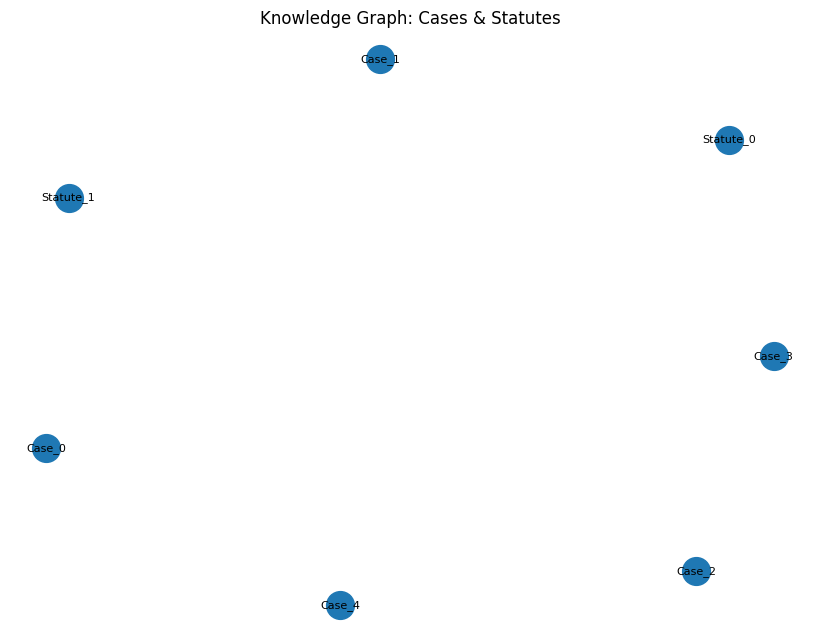

In [25]:
full_multi_agent_workflow_ollama("negligence duty of care premises liability")
